# Convolutional Neural Network

## Самостоятельная реализация светрки

In [ ]:
import torch
from torch import nn
import torchvision as tv
import time
import cv2
import numpy as np
import scipy
from scipy import misc
import matplotlib.pyplot as plt

In [15]:
scipy.__version__

'1.14.0'

In [2]:
# функция для реализации сверточного слоя
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w +1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
            print(Y)
    return Y    

In [3]:
X = torch.Tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.Tensor([[0, 1], [2, 3]])

In [4]:
X.shape

torch.Size([3, 3])

In [5]:
corr2d(X, K)

tensor([[19.,  0.],
        [ 0.,  0.]])
tensor([[19., 25.],
        [ 0.,  0.]])
tensor([[19., 25.],
        [37.,  0.]])
tensor([[19., 25.],
        [37., 43.]])


tensor([[19., 25.],
        [37., 43.]])

In [6]:
Y = torch.zeros(3 - 2 + 1, 3 - 2 + 1)
Y.shape

torch.Size([2, 2])

## Фильтры

### Изобращение с полосами

In [7]:
# генерируем изображение:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [8]:
K = torch.Tensor([[1, -1]])
K

tensor([[ 1., -1.]])

In [9]:
# функция для реализации сверточного слоя
def corr2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w +1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y  

In [10]:
# Нашли вертикальрые грани
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [11]:
# Если вертикальных граней нет
Z = corr2d(X.T, K)
print(X.T)
print(Z)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [12]:
# Траспонируем фильтр
K = K.T
K

tensor([[ 1.],
        [-1.]])

In [13]:
# Находим горизонтальные грани
Z = corr2d(X.T, K)
print(Z)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])


### Настоящее изображение

In [19]:
img = misc.ascent()
img = torch.Tensor(img)

/tmp/ipykernel_10093/4293703602.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  img = misc.ascent()


In [20]:
img.size()

torch.Size([512, 512])

In [27]:
# meke img copy
img_transformed = torch.clone(img)
size_x = img_transformed.shape[0]
size_y = img_transformed.shape[1]

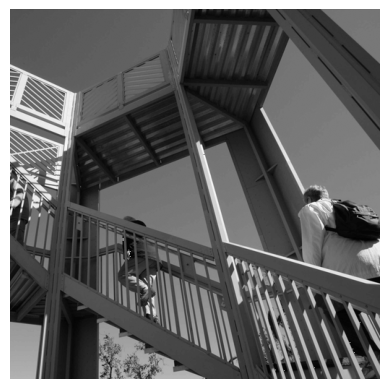

In [28]:
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(img)
plt.show()

#### Усредняющий фильтр

In [29]:
filter_ = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
print(filter_.shape)
filter_

torch.Size([3, 3])


tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])

In [30]:
def apply_filter(img, filter_):
    for x in range(1, size_x - 1):
        for y in range(1, size_y - 1):
            convolution = 0.0

            dimg = img[x - 1: x + 2, y - 1: y + 2]
            convolution = torch.sum(dimg * filter_)

            if convolution < 0:
                convolution = 0
            if convolution > 255:
                convolution = 255
            img_transformed[x, y] = convolution
    return img_transformed             

In [31]:
def plot_image(img, img_transformed):
    plt.figure(figsize=(15, 7))
    plt.gray()
    plt.grid(False)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_transformed)
    plt.show()

    ymin, ymax, xmin, xmax = 100, 200, 0, 100

    plt.figure(figsize=(15, 7))
    plt.gray()
    plt.grid(False)
    plt.subplot(1, 2, 1)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.subplot(1, 2, 2)
    plt.imshow(img_transformed[ymin:ymax, xmin:xmax])
    plt.show()

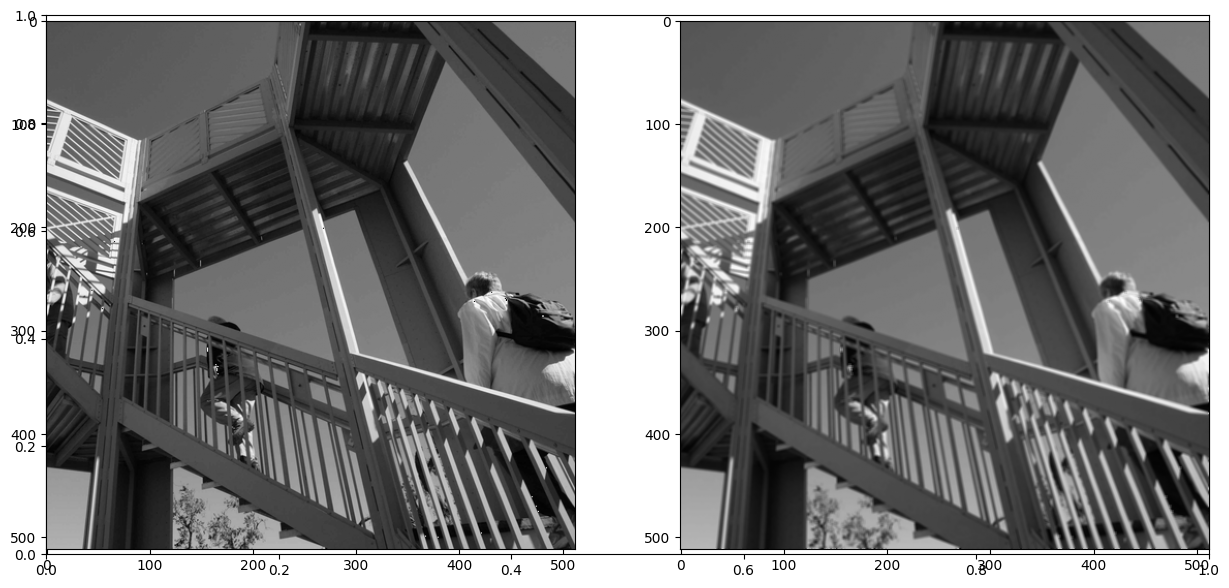

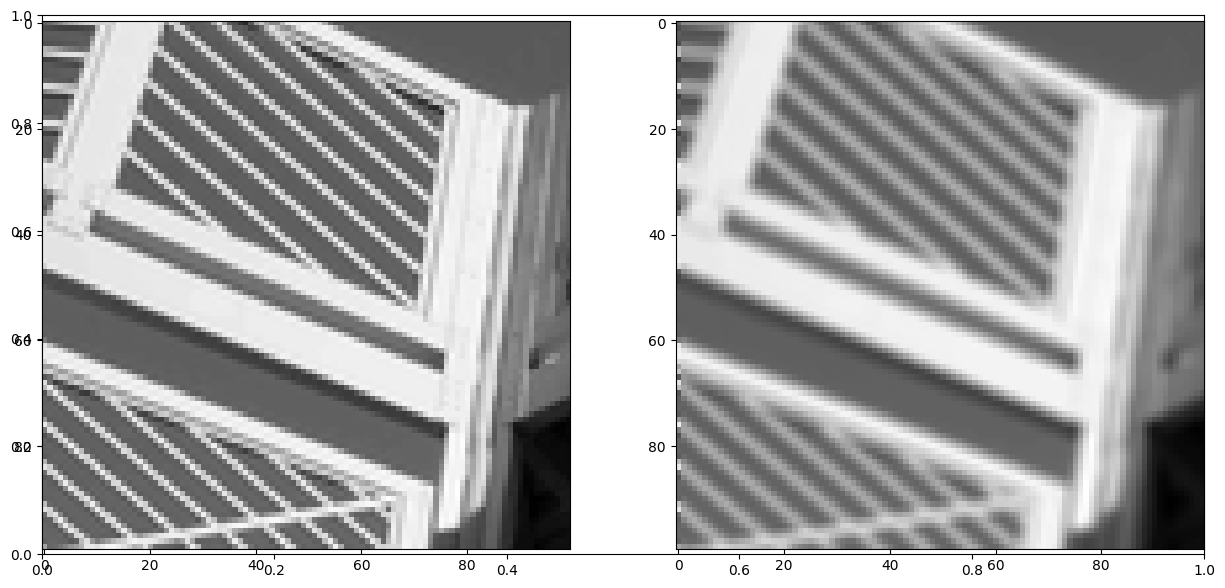

In [32]:
img_transformed = apply_filter(img, filter_)
plot_image(img, img_transformed)

#### Фильтр улучшения чёткости

In [33]:
filter_ = torch.tensor([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
print(filter_.shape)
filter_

torch.Size([3, 3])


tensor([[-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]])

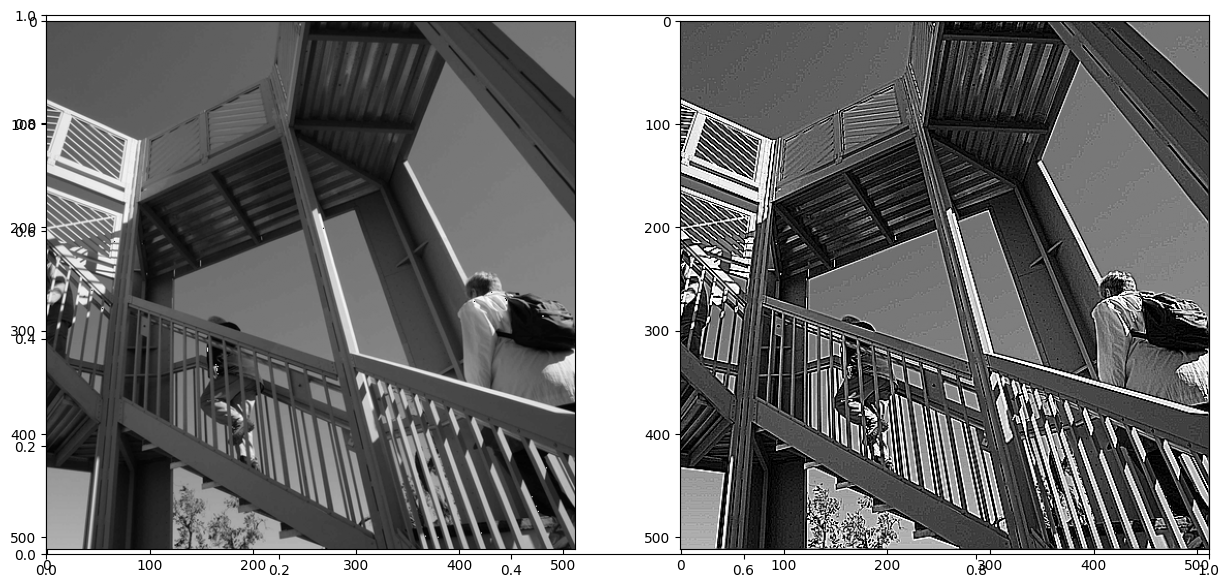

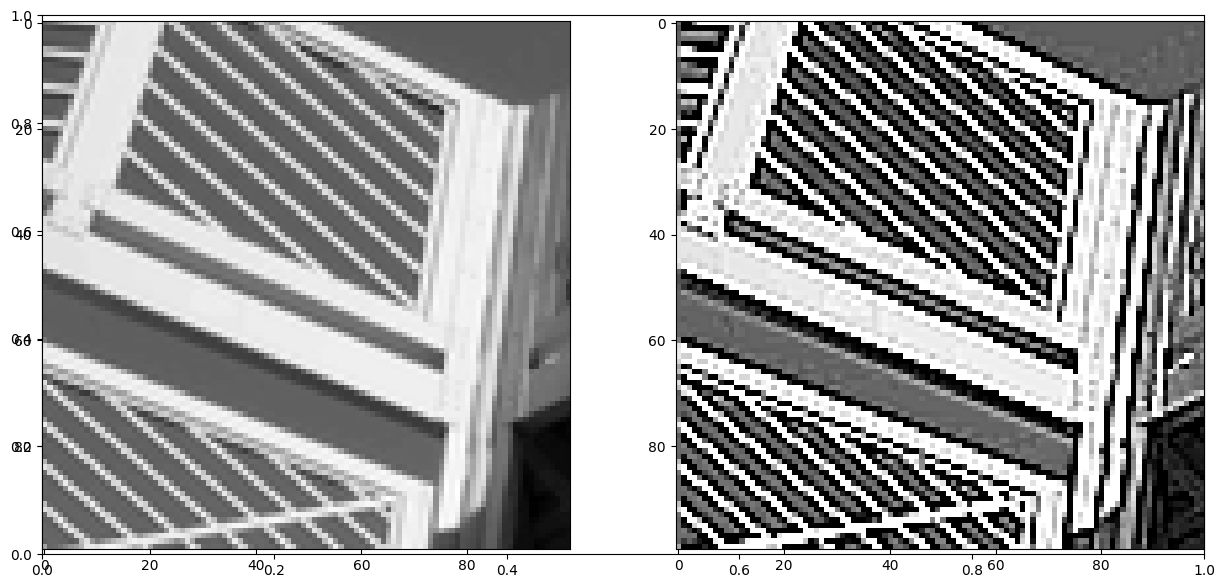

In [34]:
img_transformed = apply_filter(img, filter_)
plot_image(img, img_transformed)

#### Обнаружедие линий по горизонтали

In [35]:
filter_ = torch.tensor([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]])
print(filter_.shape)
filter_

torch.Size([3, 3])


tensor([[-1, -1, -1],
        [ 2,  2,  2],
        [-1, -1, -1]])

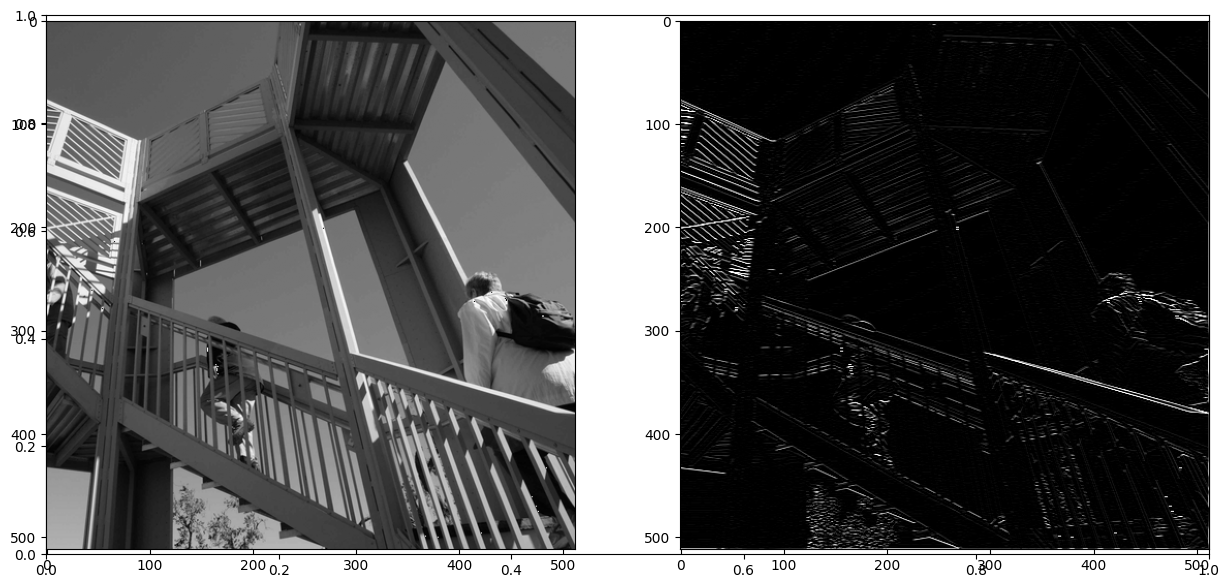

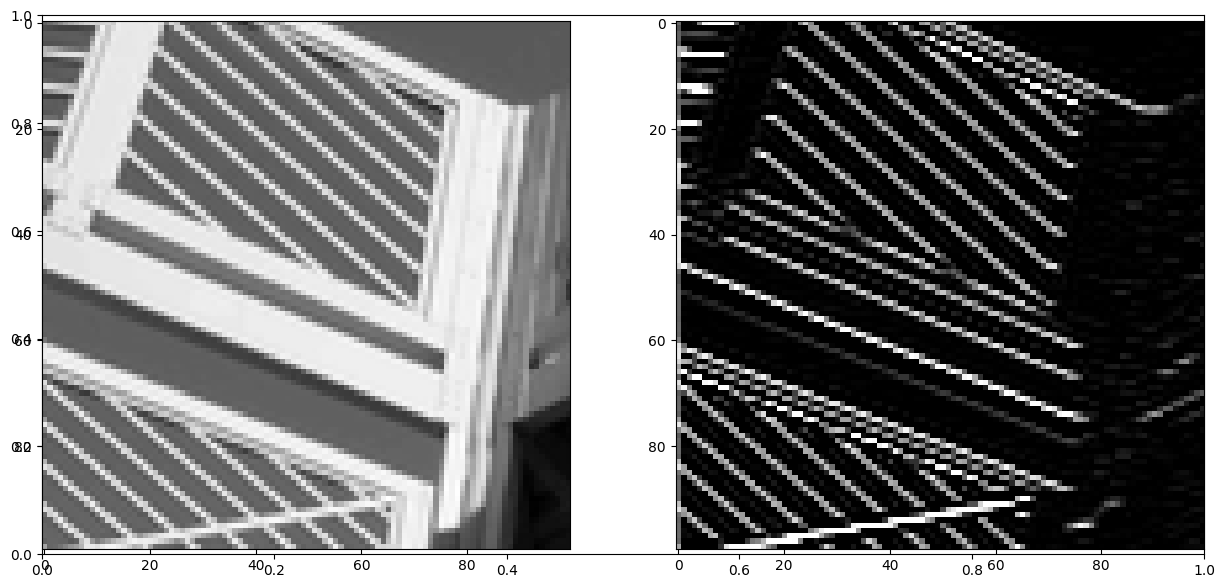

In [36]:
img_transformed = apply_filter(img, filter_)
plot_image(img, img_transformed)

## Сверточный слой

In [39]:
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)

In [40]:
X

tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]])

In [41]:
Y

tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])

In [42]:
# convolutional layer
conv2d = torch.nn.Conv2d(in_channels=1,
                         out_channels=1,
                         kernel_size=(1, 2))

In [43]:
# optimizer
optimizer = torch.optim.SGD(conv2d.parameters(), lr=.1)

In [44]:
critetion = nn.MSELoss()

In [45]:
for i in range(200):
    optimizer.zero_grad()
    Y_hat = conv2d(X)
    l = critetion(Y_hat, Y)
    l.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print(f"batch {i + 1}, loss {l.item():.3f}")

batch 10, loss 0.091
batch 20, loss 0.045
batch 30, loss 0.023
batch 40, loss 0.012
batch 50, loss 0.007
batch 60, loss 0.004
batch 70, loss 0.002
batch 80, loss 0.001
batch 90, loss 0.001
batch 100, loss 0.000
batch 110, loss 0.000
batch 120, loss 0.000
batch 130, loss 0.000
batch 140, loss 0.000
batch 150, loss 0.000
batch 160, loss 0.000
batch 170, loss 0.000
batch 180, loss 0.000
batch 190, loss 0.000
batch 200, loss 0.000


In [46]:
# look on filter
print(conv2d.weight)
print(conv2d.bias)

Parameter containing:
tensor([[[[ 0.9982, -0.9982]]]], requires_grad=True)
Parameter containing:
tensor([2.3457e-05], requires_grad=True)


## Padding and stride

### Padding

In [48]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=0)
X = torch.randn((1, 1, 8, 8))
conv2d(X).shape

torch.Size([1, 1, 6, 6])

In [53]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.randn((1, 1, 8, 8))
conv2d(X).shape

torch.Size([1, 1, 8, 8])

In [54]:
conv2d = nn.Conv2d(1, 1, kernel_size=5, padding=2)
X = torch.randn((1, 1, 8, 8))
conv2d(X).shape

torch.Size([1, 1, 8, 8])

### Stride

In [61]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
X = torch.randn((1, 1, 10, 10))
conv2d(X).shape

torch.Size([1, 1, 5, 5])

## Многоканальные изображения

In [62]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.randn((1, 1, 8, 8))
conv2d(X).shape

torch.Size([1, 1, 8, 8])

In [64]:
# смотрим веса в свертке: окно 3 x 3 и перенос с одного канала на один канал
conv2d.weight.shape

torch.Size([1, 1, 3, 3])

Получим из трехканального изображения 32 канала:

In [67]:
conv2d = nn.Conv2d(3, 32, kernel_size=3, padding=1)
X = torch.randn((1, 3, 8, 8))
conv2d(X).shape

torch.Size([1, 32, 8, 8])

Получили ваходную размерность - 32 канала

In [66]:
conv2d.weight.shape

torch.Size([32, 3, 3, 3])

Окно 3 x 3, которое переносить изображения из трех каналов в 32

## Pooling

### Усредняющий pooling

In [68]:
new_x = int(size_x / 2)
new_y = int(size_y / 2)
new_img = np.zeros((new_x, new_y))

In [69]:
for x in range(0, size_x, 2):
    for y in range(0, size_y, 2):
        pixels = []
        pixels.append(img_transformed[x, y])
        pixels.append(img_transformed[x+1, y])
        pixels.append(img_transformed[x, y+1])
        pixels.append(img_transformed[x+1, y+1])
        new_img[int(x/2), int(y/2)] = np.mean(pixels)

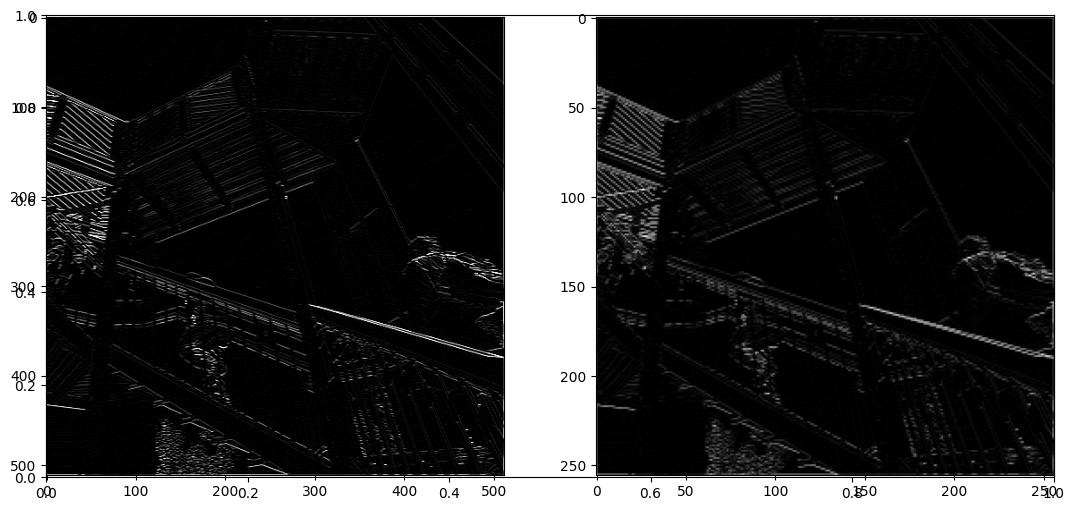

In [71]:
plt.figure(figsize=(13, 6))
plt.gray()
plt.grid(False)

plt.subplot(1, 2, 1)
plt.imshow(img_transformed)
plt.subplot(1, 2, 2)
plt.imshow(new_img)
plt.show()

### Максимальный pooling

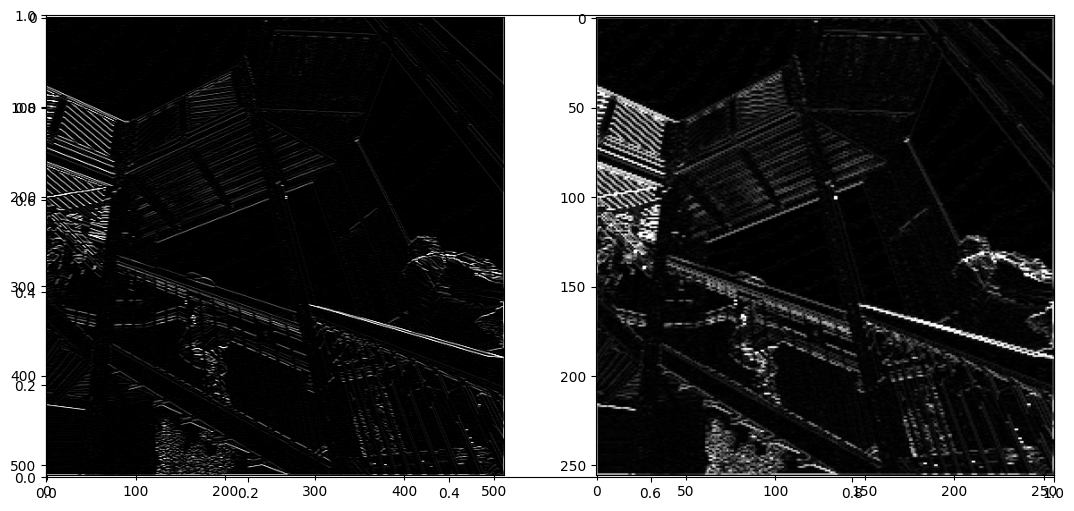

In [72]:
new_x = int(size_x / 2)
new_y = int(size_y / 2)
new_img = np.zeros((new_x, new_y))

for x in range(0, size_x, 2):
    for y in range(0, size_y, 2):
        pixels = []
        pixels.append(img_transformed[x, y])
        pixels.append(img_transformed[x+1, y])
        pixels.append(img_transformed[x, y+1])
        pixels.append(img_transformed[x+1, y+1])
        new_img[int(x/2), int(y/2)] = np.max(pixels)


plt.figure(figsize=(13, 6))
plt.gray()
plt.grid(False)

plt.subplot(1, 2, 1)
plt.imshow(img_transformed)
plt.subplot(1, 2, 2)
plt.imshow(new_img)
plt.show()        

### Максимальный pooling из pytorch

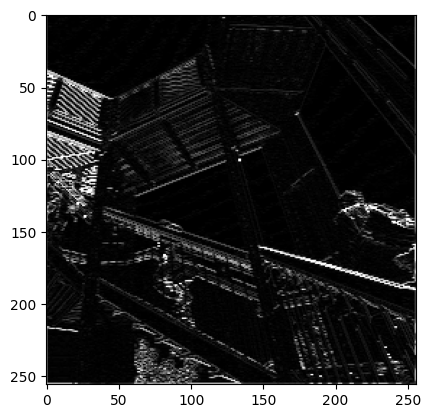

In [74]:
pool2d = nn.MaxPool2d(2)
x = pool2d(img_transformed[None])[0]
plt.imshow(x);

### Эксперименты с Pooling

In [75]:
X = torch.arange(16).reshape((1, 1, 4, 4)).type(torch.float)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [76]:
pool2d = nn.MaxPool2d(2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [77]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [78]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [80]:
pool2d = nn.MaxPool2d((2, 3), padding=(1, 1), stride=(2, 3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

### Работа pooling с многоканальными изображениями

In [81]:
X = torch.cat((X, X + 1), dim=1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [83]:
X.shape

torch.Size([1, 2, 4, 4])

In [82]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## Lenet

In [85]:
BATCH_SIZE = 256

Картинки MNIST обладают размерностью 28 x 28, а на вход Lenet поступали картинки 32 x 32. Прэтому надо искусственно увеличить размерность картинок MNIST

In [88]:
# Композиция трансфорамций:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(32),
    tv.transforms.ToTensor() # одновременно будет выполняться и масштабирование, т.е. пиксели станут от 0 до 1
])

Загружаем данные

In [91]:
train_dataset = tv.datasets.MNIST(
    './datas',
    train=True,
    transform=transforms,
    download=True
)

test_dataset = tv.datasets.MNIST(
    './datas',
    train=False,
    transform=transforms,
    download=True
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 213kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 894kB/s]


In [92]:
train_iter = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE
)

test_iter = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

In [93]:
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 5)

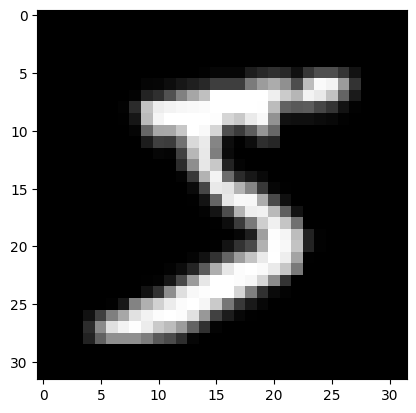

In [94]:
plt.imshow(train_dataset[0][0].numpy().reshape(32, 32), cmap='gray')

In [102]:
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Tanh(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(16, 120, kernel_size=5),
    nn.Flatten(),
    nn.Linear(120, 84), 
    nn.Tanh(),
    nn.Linear(84, 10)
)

In [103]:
model

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Tanh()
  (10): Linear(in_features=84, out_features=10, bias=True)
)

In [104]:
!uv add torchsummary

Resolved 131 packages in 0.84ms
Audited 122 packages in 0.04ms


In [105]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

Эту же информацию можно получить, выполнив следующие действия:

In [106]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 32, 32)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X.shape: {}" .format(l, X.shape))

torch.Size([1, 1, 32, 32])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)). X.shape: torch.Size([1, 6, 28, 28])
Layer Tanh(). X.shape: torch.Size([1, 6, 28, 28])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X.shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)). X.shape: torch.Size([1, 16, 10, 10])
Layer Tanh(). X.shape: torch.Size([1, 16, 10, 10])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X.shape: torch.Size([1, 16, 5, 5])
Layer Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1)). X.shape: torch.Size([1, 120, 1, 1])
Layer Flatten(start_dim=1, end_dim=-1). X.shape: torch.Size([1, 120])
Layer Linear(in_features=120, out_features=84, bias=True). X.shape: torch.Size([1, 84])
Layer Tanh(). X.shape: torch.Size([1, 84])
Layer Linear(in_features=84, out_features=10, bias=True). X.shape: torch.Size([1, 10])


In [108]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 32, 32)
y = model(X)
print(y.shape)

torch.Size([1, 10])


Функция для оценки качества работы сери:

In [109]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n    


In [110]:
def train(net, train_iter, test_iter, optimizer, num_epochs):
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for X, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        
        test_acc = evaluate_accuracy(test_iter, net)
        print(f"epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}" \
              f", test acc {test_acc:.3f}, time {time.time() - start:.1f} sec")

In [112]:
lr, num_epochs = 0.01, 5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, test_iter, optimizer, num_epochs)

epoch 1, loss 0.0090, train acc 0.115, test acc 0.200, time 22.3 sec
epoch 2, loss 0.0086, train acc 0.440, test acc 0.525, time 22.5 sec
epoch 3, loss 0.0066, train acc 0.577, test acc 0.695, time 22.8 sec
epoch 4, loss 0.0039, train acc 0.741, test acc 0.799, time 23.1 sec
epoch 5, loss 0.0027, train acc 0.812, test acc 0.837, time 23.1 sec
